Need instance segmentation mask for object detection then multiclass masks for semantic segmentation

Image shape: (2175, 2894)


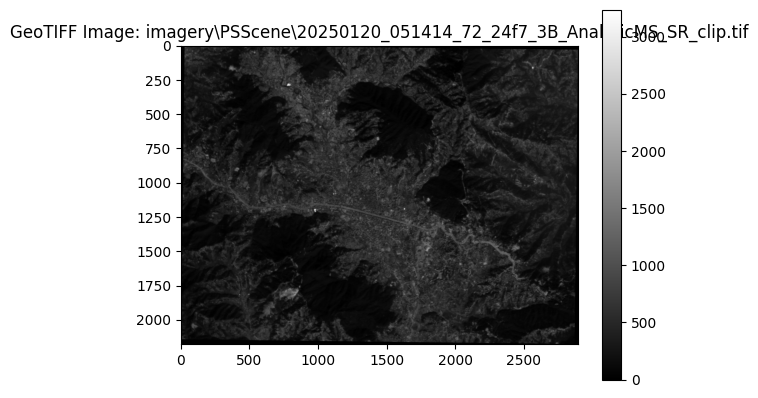

In [2]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.windows import Window
from rasterio.transform import from_origin

tif_file_path = "imagery\\PSScene\\20250120_051414_72_24f7_3B_AnalyticMS_SR_clip.tif"
with rasterio.open(tif_file_path) as src:

    img_data = src.read(1)
    print(f"Image shape: {img_data.shape}")


    plt.imshow(img_data, cmap='gray')
    plt.title(f"GeoTIFF Image: {tif_file_path}")
    plt.colorbar()
    plt.show()

In [ ]:
import os
import geopandas as gpd
from rasterio.features import rasterize
import numpy as np
from sklearn.model_selection import train_test_split

def split_image(image_path, output_dir, tile_size=256, train_ratio=0.7):
      os.makedirs(output_dir, exist_ok=True)
      for split in ['train', 'val', 'test']:
          os.makedirs(os.path.join(output_dir, split), exist_ok=True)

      with rasterio.open(image_path) as src:
          img_width, img_height = src.width, src.height
          tiles = []
          
          for i in range(0, img_width, tile_size):
              for j in range(0, img_height, tile_size):
                  if i + tile_size <= img_width and j + tile_size <= img_height:
                      tiles.append((i, j))
                      
          train_tiles, test_tiles = train_test_split(tiles, test_size= 1 - train_ratio, random_state=42)
          # 70 train
          val_tiles, test_tiles = train_test_split(test_tiles, test_size=0.5, random_state=42)
          
          tile_sets = {'train': train_tiles, 'val': val_tiles, 'test': test_tiles}
          
          for split, coords in tile_sets.items():
              for idx, (i, j) in enumerate(coords):
                  window = Window(i, j, tile_size, tile_size)
                  transform = src.window_transform(window)
                  tile = src.read(window=window)
                  output_path = os.path.join(output_dir, split, f'tile_{idx}.tif')
                  
                  with rasterio.open(
                      output_path, 'w', driver='GTiff',
                      height=tile_size, width=tile_size,
                      count=src.count, dtype=tile.dtype,
                      crs=src.crs, transform=transform
                  ) as dst:
                      dst.write(tile)

split_image(image_path='imagery\\PSScene\\20250120_051414_72_24f7_3B_AnalyticMS_SR_clip.tif',
            output_dir='data/')



In [ ]:
# display OSM outlines

In [ ]:
import json

def object_detection_annotations(geojson_path, output_json):
    gdf = gpd.read_file(geojson_path)
    annotations = []
    
    
    for idx, row in gdf.iterrows():
        if row.geometry is None or not row.geometry.is_valid:
            continue
        
        #check which idx
        bbox = row.geometry.bounds  # (minx, miny, maxx, maxy)
        annotation = {
            'image_id': idx,
            'bbox': list(bbox),
            'category_id': 1,  # Assuming all buildings belong to category 1
            'iscrowd': 0
        }
        annotations.append(annotation)
    
    annotation_data = {'annotations': annotations}
    with open(output_json, 'w') as f:
        json.dump(annotation_data, f, indent=4)


In [8]:


def segmantic_segmentation_mask(image_path, geojson_path, output_path):
    # load satellite image metadata
    with rasterio.open(image_path) as src:
        crs = src.crs
        transform = src.transform
        width = src.width
        height = src.height

    # load and reproject GeoJSON
    gdf = gpd.read_file(geojson_path).to_crs(crs)
    
    # create class mapping
    materials = gdf['roof_material'].unique()
    class_mapping = {mat: i+1 for i, mat in enumerate(materials)}

    print(class_mapping)

    shapes = [(geom, class_mapping[roof]) 
              for geom, roof in zip(gdf.geometry, gdf['roof_material'])]

    mask = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,  # background value
        dtype=np.uint8,
        all_touched=True
    )

    # save mask
    with rasterio.open(output_path, 'w', 
                       driver='GTiff',
                       height=height,
                       width=width,
                       count=1,
                       dtype=np.uint8,
                       crs=crs,
                       transform=transform) as dst:
        dst.write(mask, 1)


satellite_image_file_path = 'data\\train\\tile_0.tif' #iterate through satellite images here!
segmantic_segmentation_mask(satellite_image_file_path, "filtered_categories_buildings.geojson", "roof_mask_train_0.tif")

{'metal': 1, 'mixed': 2, 'concrete': 3, 'cgi': 4, 'roof_tiles': 5, 'rcc': 6, 'tin': 7, 'plastic': 8, 'wooden': 9}


Image shape: (256, 256)


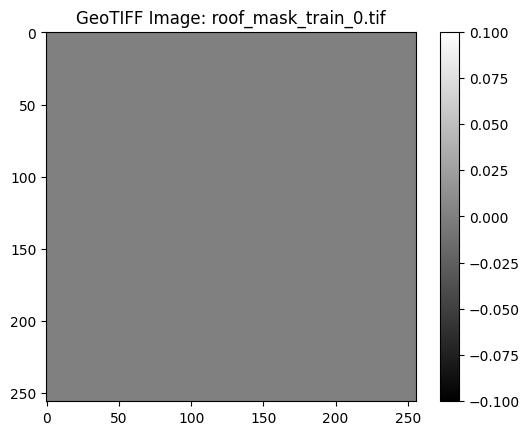

In [9]:
tif_file_path = "roof_mask_train_0.tif"
with rasterio.open(tif_file_path) as src:

    img_data = src.read(1)
    print(f"Image shape: {img_data.shape}")


    plt.imshow(img_data, cmap='gray')
    plt.title(f"GeoTIFF Image: {tif_file_path}")
    plt.colorbar()
    plt.show()